In [276]:
import pandas as pd
import seaborn as sns
import numpy as np
import collections
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [277]:
# functions
def prediction_vs_result(fit_object,original_outcomes,held_out_set):
    prediction = fit_object.predict(held_out_set)
    frame = pd.concat([original_outcomes,prediction], axis=1)
    return(frame)

# pseudo r2
def pseudor2(frame): # first column actual, second column predicted
    ss_res = (np.sum(frame.iloc[:,0] - frame.iloc[:,1]))**2
    ss_total = (np.sum(frame.iloc[:,0] - np.mean(frame.iloc[:,0])))**2
    return(1-(ss_res/ss_total))

In [278]:
refugees = pd.read_csv("refugees.csv")
refugees['date_recode'] = pd.to_datetime(refugees['date_recode'])

refugees_wlags = pd.read_csv("refugees_wlags.csv")
refugees_wlags['date_recode'] = pd.to_datetime(refugees_wlags['date_recode'])

# create a factor variable
refugees['origin_factor'], origin_labels = pd.factorize(refugees['Code_origin'])
refugees['destination_factor'], destination_labels = pd.factorize(refugees['Code_destination'])
refugees_wlags['origin_factor'], origin_labels_lags = pd.factorize(refugees_wlags['Code_origin'])
refugees_wlags['destination_factor'], destination_labels_lags = pd.factorize(refugees_wlags['Code_destination'])



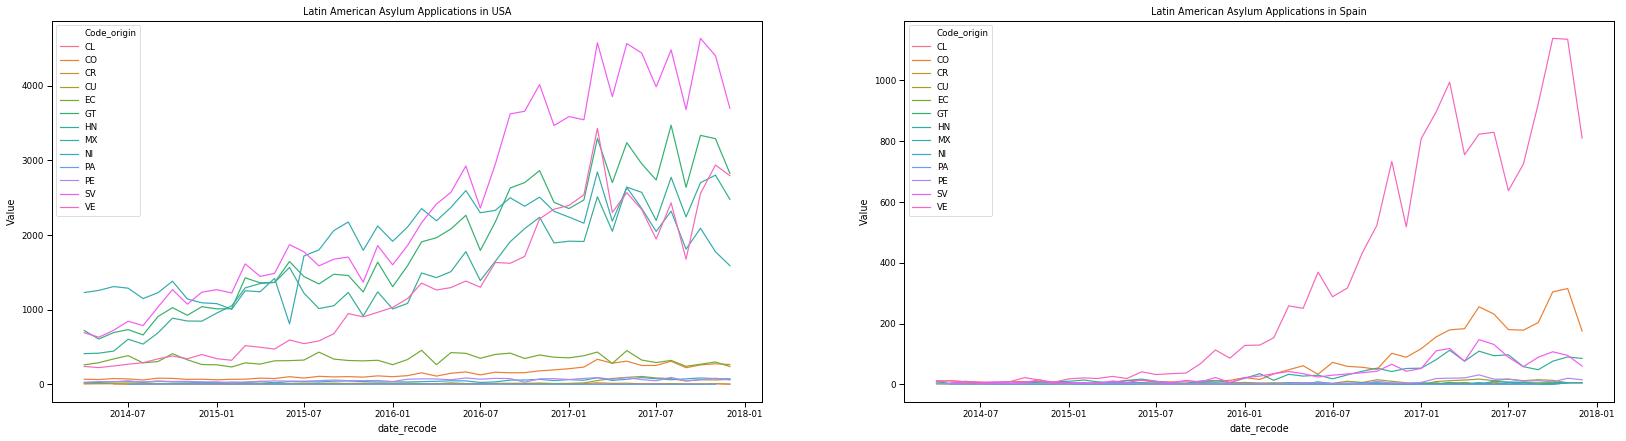

In [279]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(28,7))

# u.s.a. and spain
sns.set_context("paper",font_scale=1)
sns.lineplot(x="date_recode", y="Value", hue="Code_origin", data=refugees[refugees['Code_destination']=="US"], ax = ax1).set_title("Latin American Asylum Applications in USA")
sns.lineplot(x="date_recode", y="Value", hue="Code_origin", data=refugees[refugees['Code_destination']=="ES"], ax = ax2).set_title("Latin American Asylum Applications in Spain")
#### FIRST IDEA: compare latin american countries

plt.show()

In [280]:
# regression setup

refugees_dummies = pd.get_dummies(refugees)
#refugees_dummies['x_inmigrar_EEUU'] = refugees_dummies['inmigrar'] * refugees_dummies['EEUU']
#refugees_dummies['x_inmigrar_españa'] = refugees_dummies['inmigrar'] * refugees_dummies['españa']
#refugees_dummies['x_EEUU_españa'] = refugees_dummies['EEUU'] * refugees_dummies['españa']
refugees_no_vz = refugees_dummies[refugees_dummies.Code_origin_VE == 0]
refugees_vz = refugees_dummies[refugees_dummies.Code_origin_VE == 1]
vz_Y = refugees_vz['Value']
vz_X = refugees_vz[[col for col in refugees_vz.columns if (col != "Value") & (col != "date_recode")]]

# outcome var
Y = refugees_no_vz['Value']

# convariate matrix
X = refugees_no_vz[[col for col in refugees_no_vz.columns if (col != "Value") & (col != "date_recode")]]
X.head()

np_Y = np.asarray(Y)
np_X = np.asmatrix(X)

In [281]:
# A simple poisson model: value against term with interactions
poisson_1 = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_1_fit = poisson_1.fit()
poisson_1_pred = prediction_vs_result(poisson_1_fit, vz_Y, vz_X)
pseudor2(poisson_1_pred)

-3.985617585048981e+33

In [282]:
# oh shit. let's try negative binomial
nb_1 = sm.GLM(Y, X, family=sm.families.NegativeBinomial())
nb_1_fit = nb_1.fit()
nb_1_pred = prediction_vs_result(nb_1_fit, vz_Y, vz_X)
pseudor2(nb_1_pred)

-4.170780171571487e+33

In [283]:
# being more serious: 1-month asylum against country indicator and lagged tone

ols_1 = smf.ols('Value ~ inmigrar_EEUU_lag1 + C(Code_origin) + C(Code_destination)',data=refugees_wlags)
ols_1_fit = ols_1.fit()
ols_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.69
Date:                Fri, 26 Apr 2019   Prob (F-statistic):          5.07e-123
Time:                        16:59:16   Log-Likelihood:                -4266.0
No. Observations:                 546   AIC:                             8560.
Df Residuals:                     532   BIC:                             8620.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1139.9252    195.958     -5.817      0.000   -1524.872    -754.978
C(Code_origin)[T.CO]        580.9966    205.382      2.829      0.005     177.537     984.456
C(Code_origin)[T.CR]        -96.3806    216.037     -0.446      0.656    -520.772     328.010
C(Code_origin)[T.CU]        111.3213    222.705      0.500      0.617    -326.168     548.810
C(Code_origin)[T.EC]        219.0269    217.786      1.006      0.315    -208.799     646.852
C(Code_origin)[T.GT]       2089.9941    214.841      9.728      0.000    1667.953    2512.036
C(Code_origin)[T.HN]       1334.5085    207.528      6.430      0.000     926.833    1742.184
C(Code_origin)[T.MX]       1982.4083    211.380      9.378      0.000    1567.167    2397.649
C(Code_origin)[T.NI]          4.1963    210.735      0.020      0.984    -409.778     418.171
C(Code_origin)[T.PE]        186.6823    213.681      0.874      0.383    -233.080     606.444
C(Code_origin)[T.SV]       2107.4830    206.075     10.227      0.000    1702.662    2512.304
C(Code_origin)[T.VE]       1467.2630    203.920      7.195      0.000    1066.675    1867.851
C(Code_destination)[T.US]  1097.3246     66.500     16.501      0.000     966.690    1227.959
inmigrar_EEUU_lag1            8.9570      4.598      1.948      0.052      -0.076      17.990
==============================================================================
Omnibus:                       87.726   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.142
Skew:                           0.939   Prob(JB):                     1.02e-35
Kurtosis:                       4.887   Cond. No.                         443.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [284]:
# same as above but without destination and origin codes
ols_2 = smf.ols('Value ~ inmigrar_EEUU_lag1 + inmigrar_españa_lag1',data=refugees_wlags)
ols_2_fit = ols_2.fit()
ols_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.16
Date:                Fri, 26 Apr 2019   Prob (F-statistic):           4.67e-05
Time:                        16:59:16   Log-Likelihood:                -4568.6
No. Observations:                 546   AIC:                             9143.
Df Residuals:                     543   BIC:                             9156.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1326.2733    143.927      9.215      0.000    1043.552    1608.994
inmigrar_EEUU_lag1      -9.8521      6.694     -1.472      0.142     -23.001       3.297
inmigrar_españa_lag1   -15.8835      4.037     -3.934      0.000     -23.813      -7.953
==============================================================================
Omnibus:                      122.976   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.878
Skew:                           1.378   Prob(JB):                     1.62e-46
Kurtosis:                       4.293   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
# so when we look at the standard errors of inmigrar_lag1:EEUU_lag1. we see they're actually pretty narrow.
# so it looks like that interaction might actually be a good predictor of, perhaps, origin?

refugees_wlags['x_inmigrar_EEUU'] = refugees_wlags['inmigrar'] * refugees_wlags['EEUU']
interaction_1 = smf.ols('x_inmigrar_EEUU ~ C(Name_origin)',data=refugees_wlags)
interaction_1_fit = interaction_1.fit()
interaction_1_fit.summary()

KeyError: 'inmigrar'

In [286]:
# being more serious: 1-month asylum against country indicator and lagged tone

lag_1 = smf.ols('Value_diff ~ Value_lag1 + emigrar_EEUU_lag1 + asilo_EEUU_lag1 + asilo_españa_lag1 + emigrar_españa_lag1 + C(Code_origin) + C(Code_destination)',data=refugees_wlags)
lag_1_fit = lag_1.fit()
lag_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Value_diff   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.920
Date:                Fri, 26 Apr 2019   Prob (F-statistic):             0.0146
Time:                        16:59:28   Log-Likelihood:                -3689.6
No. Observations:                 546   AIC:                             7415.
Df Residuals:                     528   BIC:                             7493.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -45.6054     72.230     -0.631      0.528    -187.499      96.288
C(Code_origin)[T.CO]        116.6115     73.618      1.584      0.114     -28.008     261.231
C(Code_origin)[T.CR]         98.1315     80.409      1.220      0.223     -59.829     256.092
C(Code_origin)[T.CU]        183.3368     95.748      1.915      0.056      -4.756     371.430
C(Code_origin)[T.EC]        150.3034     86.733      1.733      0.084     -20.081     320.688
C(Code_origin)[T.GT]        224.5865     83.023      2.705      0.007      61.491     387.682
C(Code_origin)[T.HN]        238.7838     85.233      2.802      0.005      71.347     406.221
C(Code_origin)[T.MX]        219.5646     84.485      2.599      0.010      53.596     385.533
C(Code_origin)[T.NI]        134.3986     84.657      1.588      0.113     -31.908     300.705
C(Code_origin)[T.PE]         93.2021     75.869      1.228      0.220     -55.841     242.245
C(Code_origin)[T.SV]        283.0279     83.779      3.378      0.001     118.446     447.610
C(Code_origin)[T.VE]        320.8504     93.025      3.449      0.001     138.106     503.595
C(Code_destination)[T.US]    93.8004     28.424      3.300      0.001      37.963     149.638
Value_lag1                   -0.0606      0.015     -3.955      0.000      -0.091      -0.030
emigrar_EEUU_lag1             0.4261      2.834      0.150      0.881      -5.142       5.994
asilo_EEUU_lag1              -2.6788      3.056     -0.877      0.381      -8.682       3.324
asilo_españa_lag1             4.5049      6.613      0.681      0.496      -8.485      17.495
emigrar_españa_lag1          -8.4969      6.462     -1.315      0.189     -21.192       4.198
==============================================================================
Omnibus:                      109.855   Durbin-Watson:                   2.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1031.851
Skew:                           0.571   Prob(JB):                    8.64e-225
Kurtosis:                       9.637   Cond. No.                     3.57e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [274]:
# introducing difs

ols_2 = smf.ols('Value_diff ~ Value_lag1 + inmigrar_diff1 + EEUU_diff1 + inmigrar_diff1*EEUU_diff1 + C(Code_origin) + C(Code_destination)',data=refugees_wlags)
ols_2_fit = ols_2.fit()
ols_2_fit.summary()



PatsyError: Error evaluating factor: NameError: name 'inmigrar_diff1' is not defined
    Value_diff ~ Value_lag1 + inmigrar_diff1 + EEUU_diff1 + inmigrar_diff1*EEUU_diff1 + C(Code_origin) + C(Code_destination)
                              ^^^^^^^^^^^^^^

In [267]:
refugees_wlags

,Value,date_recode,Code_origin,Code_destination,Name_origin,Name_destination,inmigrar_EEUU,inmigrar_españa,asilo_EEUU,asilo_españa,...,inmigrar_españa_lag2,inmigrar_españa_diff1,asilo_EEUU_lag1,asilo_EEUU_lag2,asilo_EEUU_diff1,asilo_españa_lag1,asilo_españa_lag2,asilo_españa_diff1,origin_factor,destination_factor
0,0.0,2017-01-01,CL,US,Chile,United States,4.20,8.40,4.80,8.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0.0,2017-02-01,CL,US,Chile,United States,3.50,9.25,4.00,9.25,...,NaN,0.85,4.80,NaN,-0.80,8.80,NaN,0.45,0,0
2,5.0,2017-03-01,CL,US,Chile,United States,3.75,8.25,4.00,9.00,...,8.40,-1.00,4.00,4.80,0.00,9.25,8.80,-0.25,0,0
3,0.0,2017-04-01,CL,US,Chile,United States,10.20,8.80,10.40,9.20,...,9.25,0.55,4.00,4.00,6.40,9.00,9.25,0.20,0,0
4,0.0,2017-05-01,CL,US,Chile,United States,4.75,9.00,5.00,9.25,...,8.25,0.20,10.40,4.00,-5.40,9.20,9.00,0.05,0,0
5,6.0,2017-06-01,CL,US,Chile,United States,4.50,9.75,4.75,10.00,...,8.80,0.75,5.00,10.40,-0.25,9.25,9.20,0.75,0,0
6,0.0,2017-07-01,CL,US,Chile,United States,4.20,8.80,4.60,9.00,...,9.00,-0.95,4.75,5.00,-0.15,10.00,9.25,-1.00,0,0
7,0.0,2017-08-01,CL,US,Chile,United States,5.25,11.50,5.50,11.75,...,9.75,2.70,4.60,4.75,0.90,9.00,10.00,2.75,0,0
8,0.0,2017-09-01,CL,US,Chile,United States,6.25,9.00,6.25,9.50,...,8.80,-2.50,5.50,4.60,0.75,11.75,9.00,-2.25,0,0
9,0.0,2017-10-01,CL,US,Chile,United States,4.20,10.00,4.60,10.80,...,11.50,1.00,6.25,5.50,-1.65,9.50,11.75,1.30,0,0
